# GMM Approach to mean/variability 

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp

In [2]:
import numpy as np
from scipy.special import psi
from statsmodels.sandbox.regression.gmm import GMM

### Simulate some linear data

In [413]:
beta1 = np.array([5, 3]).reshape(2, -1)
beta2 = np.array([0.1, 0.2]).reshape(2, -1)
x = np.arange(0, 10, 0.001)
x = np.column_stack([np.ones(x.shape[0]), x])
y = (x@beta1).reshape(-1) + stats.norm.rvs(loc=0, scale=np.sqrt((x@beta2).reshape(-1)))
y = y.reshape(-1, 1)

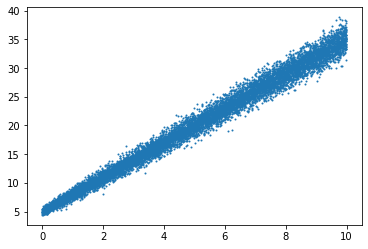

In [414]:
plt.scatter(x[:, -1], y, s=1)

In [415]:
residual = y-x@beta1

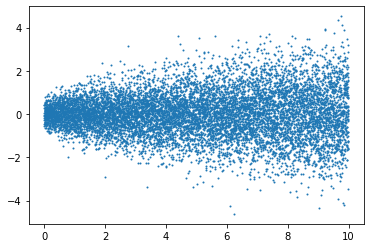

In [416]:
plt.scatter(x[:, -1], (y-x@beta1), s=1)

In [419]:
def moment_condition_linear(beta_hat):
    
    beta1_hat, beta2_hat = beta_hat[:int(beta_hat.shape[0]/2)], beta_hat[int(beta_hat.shape[0]/2):]
    residual_1 = y-x@(beta1_hat.reshape(2, -1))
    residual_mat_1 = np.tile(residual_1, (1, 2))
    error_1 = (x*residual_mat_1).mean(axis=0)
    
    residual_2 = (residual_1)**2 - x@(beta2_hat.reshape(2, -1))
    residual_mat_2 = np.tile(residual_2, (1, 2))
    error_2 = (x*residual_mat_2).mean(axis=0)
    
    return (error_2**2).sum() + (error_2**2).sum()


    #return (error_1**2).sum()
    

In [420]:
result = sp.optimize.minimize(moment_condition_linear, np.concatenate([beta1, beta2]))

In [421]:
result

      fun: 1.8799282282879586e-11
 hess_inv: array([[ 0.9956215 , -0.03521949,  0.06691455, -0.01320007],
       [-0.03521949,  0.7310829 ,  0.30279779, -0.07203674],
       [ 0.06691455,  0.30279779,  4.07062645, -0.62580274],
       [-0.01320007, -0.07203674, -0.62580274,  0.09735601]])
      jac: array([-1.09652134e-07, -1.00923530e-06,  1.39973904e-06,  1.79320001e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 432
      nit: 7
     njev: 70
   status: 2
  success: False
        x: array([5.00005058, 2.99959456, 0.1098966 , 0.19119111])

### Simulate some nonlinear data - only mean

Poisson noise process

In [121]:
def convert_params(mu, theta):
    """
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """
    r = theta
    var = mu + 1 / r * mu ** 2
    p = (var - mu) / var
    return r, 1 - p

In [189]:
num_rep = 1000
x = np.arange(0, 3, 1)
beta0 = 2
beta1 = 0.8
mean = np.exp(beta0 + beta1*x)
theta = 10*np.ones(mean.shape)
y_poi = stats.poisson.rvs(mean, size=(num_rep, x.shape[0]))
y = stats.nbinom.rvs(*convert_params(mean, theta), size=(num_rep, x.shape[0]))
x = np.tile(x, (1, num_rep)).reshape(-1)
y = y.reshape(-1)
y_poi = y_poi.reshape(-1)


x_mat = np.column_stack([np.ones(x.shape[0]), x])

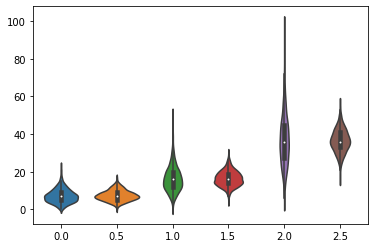

In [190]:
sns.violinplot(pd.Series(np.concatenate([x, x+0.5])), np.concatenate([y, y_poi]))
#sns.violinplot(pd.Series(x)+0.5, y_poi)

In [191]:
def moment_condition_loglinear(beta_hat):
    
    residual = y.reshape(-1, 1)-np.exp(x_mat@beta_hat.reshape(2, -1))
    residual_mat = np.tile(residual, (1, 2))
    error = (x_mat*residual_mat).mean(axis=0)
    return (error**2).sum()
    

In [192]:
%%time
result = sp.optimize.minimize(
    moment_condition_loglinear, 
    np.array([0, 0]),
    method='Nelder-Mead')

CPU times: user 70.6 ms, sys: 866 µs, total: 71.5 ms
Wall time: 69.4 ms


In [193]:
result

 final_simplex: (array([[1.98747555, 0.80899647],
       [1.98754866, 0.80895561],
       [1.98743267, 0.80902711]]), array([2.78193787e-08, 5.79704193e-08, 5.95889573e-08]))
           fun: 2.781937870365178e-08
       message: 'Optimization terminated successfully.'
          nfev: 152
           nit: 80
        status: 0
       success: True
             x: array([1.98747555, 0.80899647])

### Simulate some data with varying dispersion

In [1096]:
def convert_params(mu, theta):
    """
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """
    r = theta
    var = mu + 1 / r * mu ** 2
    p = (var - mu) / var
    return r, 1 - p

In [1106]:
num_rep = 1000
x = np.arange(0, 5, 1)
x = np.tile(x, (1, num_rep)).reshape(-1)
x_mat = np.column_stack([np.ones(x.shape[0]), x])
beta1 = np.array([2, 1])
beta2 = np.array([1, -0.1])
p = 1.5
mean = np.exp(x_mat@beta1)
var = np.exp(x_mat@beta2) * (mean**p)
#y = stats.poisson.rvs(mean, size=(num_rep, x.shape[0]))
y = stats.nbinom.rvs(*convert_params(mean, 1/((var-mean)/mean**2)))
y = y.reshape(-1)

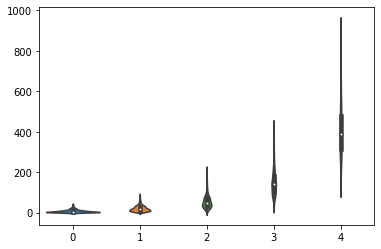

In [1107]:
sns.violinplot(pd.Series(x), y)

In [1108]:
def deconstruct_params(params):
    
    beta1 = params[:2]
    beta2 = params[2:4]
    #p_hat = params[-1]
    
    return beta1, beta2

In [1113]:
def moment_condition_loglinear(params):
    
    beta1_hat, beta2_hat = deconstruct_params(params)
    
    # Mean
    residual1 = y.reshape(-1, 1) - np.exp(x_mat@beta1_hat.reshape(2, -1))
    residual_mat_1 = np.tile(residual1, (1, 2))
    error_1 = (x_mat*residual_mat_1).mean(axis=0)
    
    # Variance
    residual2 = (residual1**2) - (np.exp(x_mat@beta1_hat.reshape(2, -1))*np.exp(x_mat@beta2_hat.reshape(2, -1)))
    residual_mat_2 = np.tile(residual2, (1, 2))
    error_2 = (x_mat*residual_mat_2).mean(axis=0)
    
    return np.concatenate([error_1, error_2])
    

In [1114]:
%%time
init = np.ones(4)*(np.log(y+1).mean()/4)
print(init.shape)
#init = np.concatenate([beta1, beta2])
result_2 = sp.optimize.fsolve(
    moment_condition_loglinear, 
    init)

(4,)
CPU times: user 86 ms, sys: 0 ns, total: 86 ms
Wall time: 83.7 ms


In [1115]:
beta1_hat, beta2_hat = deconstruct_params(result_2)

In [1116]:
print(beta1_hat, beta2_hat)

[1.9820709  1.00548358] [1.99879325 0.40638994]


### Dropout

In [1093]:
p = 0.1
noise_level = 0.2049755522580501
p_sq = (noise_level+1)*p**2
m = p
v = p_sq - p**2
alpha = m*(m*(1-m)/v - 1)
beta = (1-m)*(m*(1-m)/v - 1)

In [1094]:
num_rep = 3000
x = np.arange(0, 4, 1)
x = np.tile(x, (1, num_rep)).reshape(-1)
x_mat = np.column_stack([np.ones(x.shape[0]), x])
beta1 = np.array([1, 0.8])
beta2 = np.array([0.1, 0.0])
mean = np.exp(x_mat@beta1)
var = np.exp(x_mat@beta2) * mean
#y = stats.poisson.rvs(mean, size=(num_rep, x.shape[0]))
y = stats.nbinom.rvs(*convert_params(mean, 1/((var-mean)/mean**2)))
qs = stats.beta.rvs(alpha, beta, size=y.shape)
y_obs = stats.binom.rvs(y, qs)
y = y.reshape(-1)
y_obs = y_obs.reshape(-1)

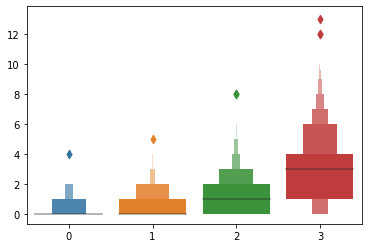

In [1095]:
sns.boxenplot(pd.Series(x), y_obs)

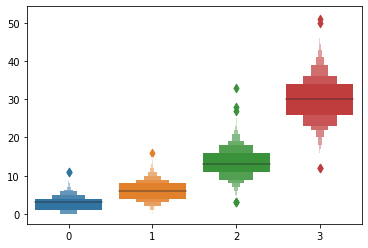

In [712]:
sns.boxenplot(pd.Series(x), y)

In [713]:
def moment_condition_loglinear(beta_hat):
    
    beta1_hat, beta2_hat = beta_hat[:int(beta_hat.shape[0]/2)], beta_hat[int(beta_hat.shape[0]/2):]
    
    residual1 = y_obs.reshape(-1, 1)/p - np.exp(x_mat@beta1_hat.reshape(2, -1))
    residual_mat_1 = np.tile(residual1, (1, 2))
    error_1 = (x_mat*residual_mat_1).mean(axis=0)
    
    residual2 = (residual1**2) - (np.exp(x_mat@(beta1_hat + beta2_hat).reshape(2, -1)))
    residual_mat_2 = np.tile(residual2, (1, 2))
    error_2 = (x_mat*residual_mat_2).mean(axis=0)
    
    return np.concatenate([error_1, error_2])
    #return (error_1**2).sum()# + (error_2**2).sum()
    

In [767]:
%%time
init = np.ones(4)*(np.log(y+1).mean()/4) #np.concatenate([beta1, beta2])
init = np.concatenate([beta1, beta2])
result = sp.optimize.fsolve(
    moment_condition_loglinear, 
    init)

CPU times: user 43.3 ms, sys: 942 µs, total: 44.3 ms
Wall time: 43.3 ms


In [768]:
result

array([ 2.0003989 ,  0.99989737,  1.11998413, -0.0111784 ])

### Simulate some data

In [421]:
def convert_params(mu, theta):
    """
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """
    r = theta
    var = mu + 1 / r * mu ** 2
    p = (var - mu) / var
    return r, 1 - p



In [422]:
data = pd.DataFrame()
data['x'] = x
data['y'] = y

In [435]:
beta1 = 0.3
beta2 = 2
x = np.arange(1, 10, 1)
means = np.exp(beta1*x)
thetas = np.exp(beta2*x)
y = stats.nbinom.rvs(*convert_params(means, thetas), size=(50, x.shape[0]))
x = np.tile(x, (1, 50)).reshape(-1)
y = y.reshape(-1)

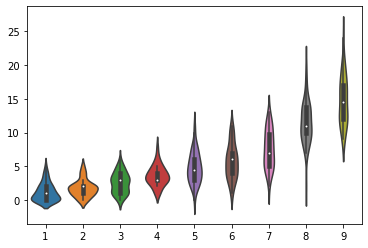

In [436]:
sns.violinplot(
pd.Series(x),
y.reshape(-1))

### Sample

In [470]:
class GMMGamma(GMM):

    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 4)
        kwds.setdefault('k_params', 2)
        super(GMMGamma, self).__init__(*args, **kwds)


    def momcond(self, params):
        print(params.shape)
        print(self.endog.shape)
        print(self.exog.shape)
        p0, p1 = params
        endog = self.endog
        error1 = endog - p0 / p1
        error2 = endog**2 - (p0 + 1) * p0 / p1**2
        error3 = 1 / endog - p1 / (p0 - 1)
        error4 = np.log(endog) + np.log(p1) - psi(p0)
        g = np.column_stack((error1, error2, error3, error4))
        return g

In [471]:
y = np.array([20.5, 31.5, 47.7, 26.2, 44.0, 8.28, 30.8, 17.2, 19.9, 9.96, 55.8, 25.2, 29.0, 85.5, 15.1, 28.5, 21.4, 17.7, 6.42, 84.9])

In [472]:
y.shape

(20,)

In [473]:
nobs = y.shape[0]
x = np.ones((nobs, 4))

model = GMMGamma(y, x, None)
beta0 = np.array([2, 0.1])
res = model.fit(beta0, maxiter=2, optim_method='nm', wargs=dict(centered=False))
print(res.summary())

(2,)
(20,)
(20, 4)


NameError: name 'residual' is not defined

### Set up the GMM as if the latent variables were observed

In [453]:
class gmm(GMM):

    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 1)
        kwds.setdefault('k_params', 1)
        super(gmm, self).__init__(*args, **kwds)

    def momcond(self, params):
        
        params = params[0]
        return (self.exog*(self.endog - params*self.exog))


In [454]:
y.shape

(450,)

In [455]:
x.shape

(450,)

In [456]:
model = gmm(y, x, None)
beta0 = 0.5
res = model.fit(beta0, maxiter=2, optim_method='nm', wargs=dict(centered=False))

ValueError: shapes (450,) and (1,1) not aligned: 450 (dim 0) != 1 (dim 0)

### Binomial beta case

In [4]:
p = 0.1

In [35]:
distances = []
Ns = np.arange(5, 5000, 1)

for N in Ns:
    
    binom_x = np.arange(0, N, 1)
    binom_y = stats.binom.pmf(np.arange(0, N, 1), N, p)
    binom_x = binom_x / N
    binom_y = binom_y * N
    
    beta_x = binom_x
    beta_y = stats.beta.pdf(beta_x, N*p, N*(1-p))
    
    
    
    distances.append(((binom_y - beta_y)**2).mean())

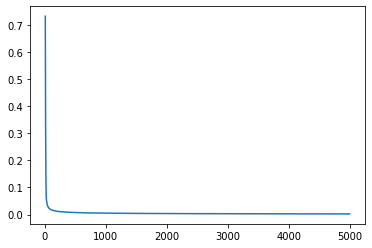

In [36]:
plt.plot(Ns, distances)

In [37]:
distances[-1:]

[0.002242356154609695]

In [77]:
N = 1000
p = 0.5

In [78]:
binom_x = np.arange(0, N, 1)
binom_y = stats.binom.pmf(np.arange(0, N, 1), N, p)
binom_x = binom_x / N
binom_y = binom_y * N

In [100]:
p = 0.1
noise_level = 0.2049755522580501
p_sq = (noise_level+1)*p**2

In [101]:
m = p
v = p_sq - p**2

In [104]:
alpha = m*(m*(1-m)/v - 1)
beta = (1-m)*(m*(1-m)/v - 1)

In [105]:
qs = stats.beta.rvs(alpha, beta, size=10000)

In [106]:
qs.var()

0.002001210874947601

(0, 1)

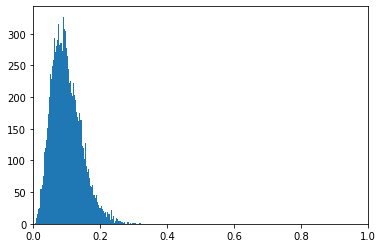

In [107]:
plt.hist(qs, bins=100);
plt.xlim(0, 1)

(0, 1)

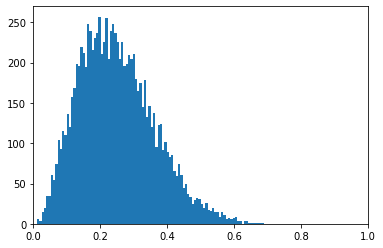

In [76]:
plt.hist(qs, bins=100);
plt.xlim(0, 1)

1000


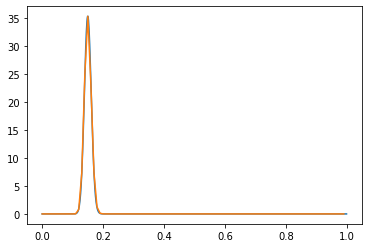

In [31]:
plt.plot(binom_x, binom_y)
print(N)


plt.plot(np.arange(0, 1, 0.01), stats.beta.pdf(np.arange(0, 1, 0.01), N*p, N*(1-p)))

25


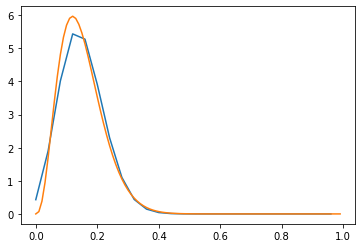

In [28]:
plt.plot(binom_x, binom_y)
print(N)
plt.plot(np.arange(0, 1, 0.01), stats.beta.pdf(np.arange(0, 1, 0.01), N*p, N*(1-p)))

10


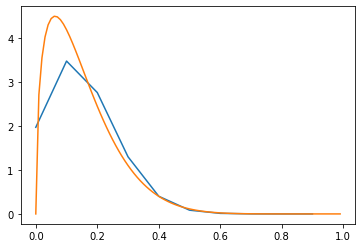

In [20]:
plt.plot(binom_x, binom_y)
print(N)
plt.plot(np.arange(0, 1, 0.01), stats.beta.pdf(np.arange(0, 1, 0.01), N*p, N*(1-p)))

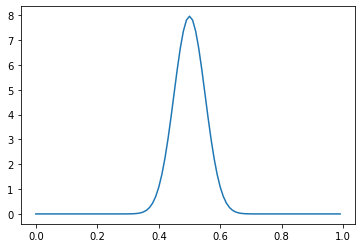

In [14]:
plt.plot(np.arange(0, 1, 0.01), stats.beta.pdf(np.arange(0, 1, 0.01), N*p, N*(1-p)))

### Computing ASL

In [63]:
a = stats.norm.rvs(loc=-3.5, size=5000)
b = stats.norm.rvs(loc=3.5, size=5000)

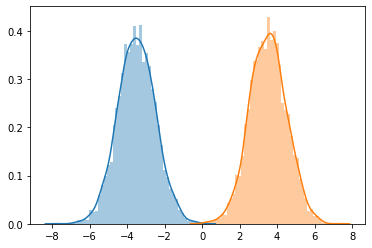

In [64]:
sns.distplot(a)
sns.distplot(b)

In [65]:
import itertools

In [66]:
sig = 0

In [70]:
%%time
(np.array([(x-y) for x,y in itertools.product(a,b)]) > 0).sum()

CPU times: user 5.67 s, sys: 949 ms, total: 6.62 s
Wall time: 6.61 s


4

In [71]:
%%time
sig = 0
for x, y in itertools.product(a,b):
    
    if x > y:
        sig += 1
print(sig)

4
CPU times: user 3.66 s, sys: 13.2 ms, total: 3.68 s
Wall time: 3.69 s


In [51]:
np.array([(x-y) for x,y in itertools.product(a,b)]) > 0)

KeyboardInterrupt: 